In [1]:
import pandas as pd
import seaborn as sns
from statsmodels.stats.inter_rater import fleiss_kappa, aggregate_raters

In [14]:
grey = (187/255, 187/255, 187/255)
darkgreen = (51/255, 117/255, 56/255)
teal = (93/255, 168/255, 153/255)
blue = (148/255, 203/255, 236/255)
yellow = (220/255, 205/255, 125/255)

# Grade Analysis

In [71]:
grade_df = pd.read_csv('Menagerie/data/grades.csv', index_col=0)
grade_df = grade_df[~grade_df['grade'].isnull()]
grade_df['grade'] = pd.Categorical(grade_df['grade'],
                                         ['A++', 'A+', 'A', 'A-',
                                          'B+', 'B', 'B-',
                                          'C+', 'C', 'C-',
                                          'D+', 'D', 'D-',
                                          'F', 'NAN'])
# Removed as this was accidentally duplicated
grade_df = grade_df[grade_df['assignment_number'] != 105]
grade_df

,assignment_number,comments,skill,participant_id,batch,grade
0,18.0,The code use meaningful identifier names and a...,Readability,15,1,B+
1,620.0,Code is well organized into logical classes an...,Readability,15,1,A+
2,466.0,"The code is well-organized, consistently inden...",Readability,15,1,A-
3,591.0,The code is well organized and readable. Inden...,Readability,15,1,A-
4,587.0,The code is well organized and readable. Inden...,Readability,15,1,A-
...,...,...,...,...,...,...
15,58.0,NaN,Documentation,14,1,A++
16,353.0,NaN,Documentation,14,1,A++
17,422.0,NaN,Documentation,14,1,A++
18,480.0,NaN,Documentation,14,1,A++


# Inter-Rater Analysis

In [82]:
def calculate_fleiss_kappa(skill, participant_list, grade_col):
    skill_df = grade_df[grade_df['skill'] == skill][['participant_id', 'assignment_number', grade_col]]
    group_df = skill_df[skill_df['participant_id'].isin(participant_list)].sort_values(by='participant_id')
    pivot = group_df.pivot(index='assignment_number', columns='participant_id', values=grade_col)
    if any(pivot.isna().any(axis=1)):
        print('Missing Grade: ', pivot[pivot.isna().any(axis=1)])
        pivot.dropna(inplace=True)
  
    return fleiss_kappa(aggregate_raters(pivot)[0], 'fleiss')

In [83]:
def calculate_all_fleiss_kappa(grade_col):
    results_df = None
    
    for skill in ['Correctness', 'Readability', 'Code Elegance', 'Documentation']:
        for i in range(1, 28, 4):
            group = list(range(i, i + 4))
            group_str = str(group[0]) + '-' + str(group[-1])
            try:
                results_df = pd.concat([results_df, pd.DataFrame({
                                        'group': group_str,
                                        'skill': skill,
                                        'fliess_kappa': calculate_fleiss_kappa(skill, group, grade_col)}, index=[0])])
            except ValueError:
                print('Error duplicate entries check data for: ', group_str)
    
    return results_df

In [92]:
results_df = calculate_all_fleiss_kappa('grade')
results_df

Missing Grade:  participant_id      13  14  15 16
assignment_number                
306.0              NaN  A+  B+  A
Missing Grade:  participant_id      21   22   23  24
assignment_number                   
10.0               NaN   A+   D+   F
410.0              NaN   C+   A+  A-
654.0              NaN  A++  A++  D-
Missing Grade:  participant_id      9  10  11  12
assignment_number                
117.0              NaN  B  A+  A-
Missing Grade:  participant_id      25   26   27   28
assignment_number                    
394.0              A++  A++  NaN  A++


,group,skill,fliess_kappa
0,1-4,Correctness,0.042673
0,5-8,Correctness,-0.024104
0,9-12,Correctness,0.003440
0,13-16,Correctness,0.041807
0,17-20,Correctness,0.113360
0,21-24,Correctness,0.128276
0,25-28,Correctness,0.046496
0,1-4,Readability,-0.002874
0,5-8,Readability,-0.070433
0,9-12,Readability,-0.069315


### Average Fliess Kappa
#### Skill

In [86]:
results_df[['skill', 'fliess_kappa']].groupby('skill').mean().reset_index()

,skill,fliess_kappa
0,Code Elegance,0.015278
1,Correctness,0.050278
2,Documentation,-0.014126
3,Readability,-0.013877


#### Group

In [87]:
results_df[['group', 'fliess_kappa']].groupby('group').mean().reset_index()

,group,fliess_kappa
0,1-4,0.009584
1,13-16,-0.000166
2,17-20,0.035506
3,21-24,0.036410
4,25-28,0.066987
5,5-8,-0.044771
6,9-12,-0.037831


## Less granular analysis

In [78]:
grade_df['primary_grade'] = grade_df['grade'].apply(lambda x: x[0])
grade_df

,assignment_number,comments,skill,participant_id,batch,grade,primary_grade
0,18.0,The code use meaningful identifier names and a...,Readability,15,1,B+,B
1,620.0,Code is well organized into logical classes an...,Readability,15,1,A+,A
2,466.0,"The code is well-organized, consistently inden...",Readability,15,1,A-,A
3,591.0,The code is well organized and readable. Inden...,Readability,15,1,A-,A
4,587.0,The code is well organized and readable. Inden...,Readability,15,1,A-,A
...,...,...,...,...,...,...,...
15,58.0,NaN,Documentation,14,1,A++,A
16,353.0,NaN,Documentation,14,1,A++,A
17,422.0,NaN,Documentation,14,1,A++,A
18,480.0,NaN,Documentation,14,1,A++,A


In [88]:
results_df = calculate_all_fleiss_kappa('primary_grade')
results_df

Missing Grade:  participant_id      13 14 15 16
assignment_number              
306.0              NaN  A  B  A
Missing Grade:  participant_id      21 22 23 24
assignment_number              
10.0               NaN  A  D  F
410.0              NaN  C  A  A
654.0              NaN  A  A  D
Missing Grade:  participant_id      9  10 11 12
assignment_number              
117.0              NaN  B  A  A
Missing Grade:  participant_id    25 26   27 28
assignment_number              
394.0              A  A  NaN  A


,group,skill,fliess_kappa
0,1-4,Correctness,0.245128
0,5-8,Correctness,-0.016199
0,9-12,Correctness,0.054746
0,13-16,Correctness,0.276003
0,17-20,Correctness,0.266433
0,21-24,Correctness,0.379183
0,25-28,Correctness,0.284534
0,1-4,Readability,0.141092
0,5-8,Readability,-0.061360
0,9-12,Readability,-0.010668


### Average Fliess Kappa
#### Skill

In [89]:
results_df[['skill', 'fliess_kappa']].groupby('skill').mean().reset_index()

,skill,fliess_kappa
0,Code Elegance,0.036890
1,Correctness,0.212833
2,Documentation,0.042658
3,Readability,0.056083


#### Group

In [91]:
results_df[['group', 'fliess_kappa']].groupby('group').mean().reset_index()

,group,fliess_kappa
0,1-4,0.162603
1,13-16,0.053868
2,17-20,0.102609
3,21-24,0.116759
4,25-28,0.256731
5,5-8,-0.058881
6,9-12,-0.023879


# Intra-Rater Relability

In [9]:
DUPLICATE_MAP = {
    680: 144,
    681: 559,
    682: 97,
    683: 358,
    684: 389,
    685: 160,
    686: 176
}

In [10]:
intra_rater_df = grade_df[grade_df['assignment_number'].isin(list(DUPLICATE_MAP.keys())+list(DUPLICATE_MAP.values()))][['assignment_number', 'skill', 'participant_id', 'batch', 'grade']]
intra_rater_df = intra_rater_df.sort_values('grade')
intra_rater_df

,assignment_number,skill,participant_id,batch,grade
7,680.0,Correctness,3,2,A++
13,685.0,Readability,22,2,A++
9,686.0,Code Elegance,25,2,A++
7,680.0,Readability,3,2,A++
16,684.0,Code Elegance,18,2,A++
...,...,...,...,...,...
14,682.0,Documentation,10,2,F
7,97.0,Code Elegance,10,1,F
7,97.0,Correctness,10,1,F
7,97.0,Readability,10,1,F


### Map replacement IDs to original IDs

In [11]:
intra_rater_df['assignment_number'] = intra_rater_df['assignment_number'].apply(lambda x: x if x not in DUPLICATE_MAP.keys() else DUPLICATE_MAP[x])
intra_rater_df

,assignment_number,skill,participant_id,batch,grade
7,144.0,Correctness,3,2,A++
13,160.0,Readability,22,2,A++
9,176.0,Code Elegance,25,2,A++
7,144.0,Readability,3,2,A++
16,389.0,Code Elegance,18,2,A++
...,...,...,...,...,...
14,97.0,Documentation,10,2,F
7,97.0,Code Elegance,10,1,F
7,97.0,Correctness,10,1,F
7,97.0,Readability,10,1,F


### Check if the graders graded the same for both batch 1 and batch 2

In [12]:
match_df = intra_rater_df.pivot(index=['assignment_number', 'skill', 'participant_id'], columns='batch', values='grade').reset_index()
match_df['match'] = match_df[1] == match_df[2]
match_df.columns = ['assignment_number', 'skill', 'participant_id', 'grade_1', 'grade_2', 'match']
match_df

,assignment_number,skill,participant_id,grade_1,grade_2,match
0,97.0,Code Elegance,9,A-,B+,False
1,97.0,Code Elegance,10,F,F,True
2,97.0,Code Elegance,11,A-,A+,False
3,97.0,Code Elegance,12,A-,B,False
4,97.0,Correctness,9,B+,A,False
...,...,...,...,...,...,...
107,559.0,Documentation,8,A,A,True
108,559.0,Readability,5,A-,B+,False
109,559.0,Readability,6,A-,A++,False
110,559.0,Readability,7,A+,A+,True


### Count the matches per skill

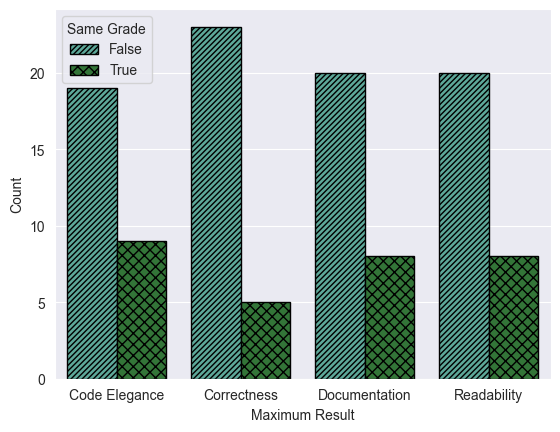

In [70]:
skill_match_plt = sns.barplot(match_df.groupby(['skill', 'match']).count(), x='skill', y='grade_1', hue='match')
skill_match_plt.set(xlabel='Skill', ylabel='Count')

hatches = ['//', 'x']
colors = [teal, darkgreen]
styles = zip(hatches, colors)

for style, these_bars in zip(styles, skill_match_plt.containers):
    for this_bar in these_bars:
        this_bar.set_hatch(3 * style[0])
        this_bar.set_facecolor(style[1])
        this_bar.set_edgecolor('black')

skill_match_plt.set(xlabel='Maximum Result', ylabel='Count')
handles = skill_match_plt.get_legend_handles_labels()[0]

for i in range(len(handles)):
    handles[i].set_facecolor(colors[i])
    handles[i].set_hatch(3 * hatches[i])
    handles[i].set_edgecolor('black')


skill_match_plt.legend(title='Same Grade')
skill_match_plt.get_figure().savefig('plots/skill_match.pdf', bbox_inches='tight')

### Count of match per grade

/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_46899/384615156.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grade_match_plt = sns.barplot(match_df.groupby(['grade_1', 'match']).count(), x='grade_1', y='grade_2', hue='match')


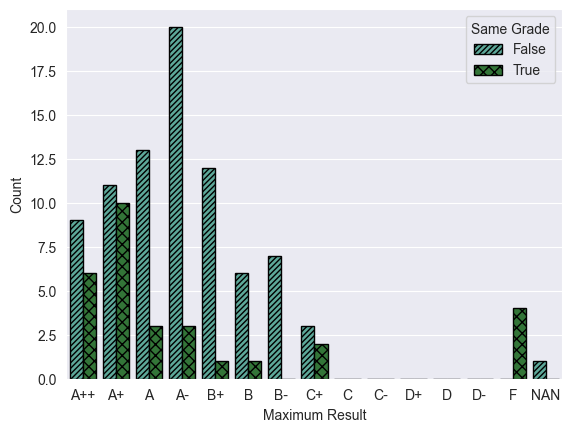

In [69]:
grade_match_plt = sns.barplot(match_df.groupby(['grade_1', 'match']).count(), x='grade_1', y='grade_2', hue='match')
grade_match_plt.set(xlabel='Grade', ylabel='Count')

hatches = ['//', 'x']
colors = [teal, darkgreen]
styles = zip(hatches, colors)

for style, these_bars in zip(styles, grade_match_plt.containers):
    for this_bar in these_bars:
        this_bar.set_hatch(3 * style[0])
        this_bar.set_facecolor(style[1])
        this_bar.set_edgecolor('black')

grade_match_plt.set(xlabel='Maximum Result', ylabel='Count')
handles = grade_match_plt.get_legend_handles_labels()[0]

for i in range(len(handles)):
    handles[i].set_facecolor(colors[i])
    handles[i].set_hatch(3 * hatches[i])
    handles[i].set_edgecolor('black')


grade_match_plt.legend(title='Same Grade')
grade_match_plt.get_figure().savefig('plots/grade_match.pdf', bbox_inches='tight')

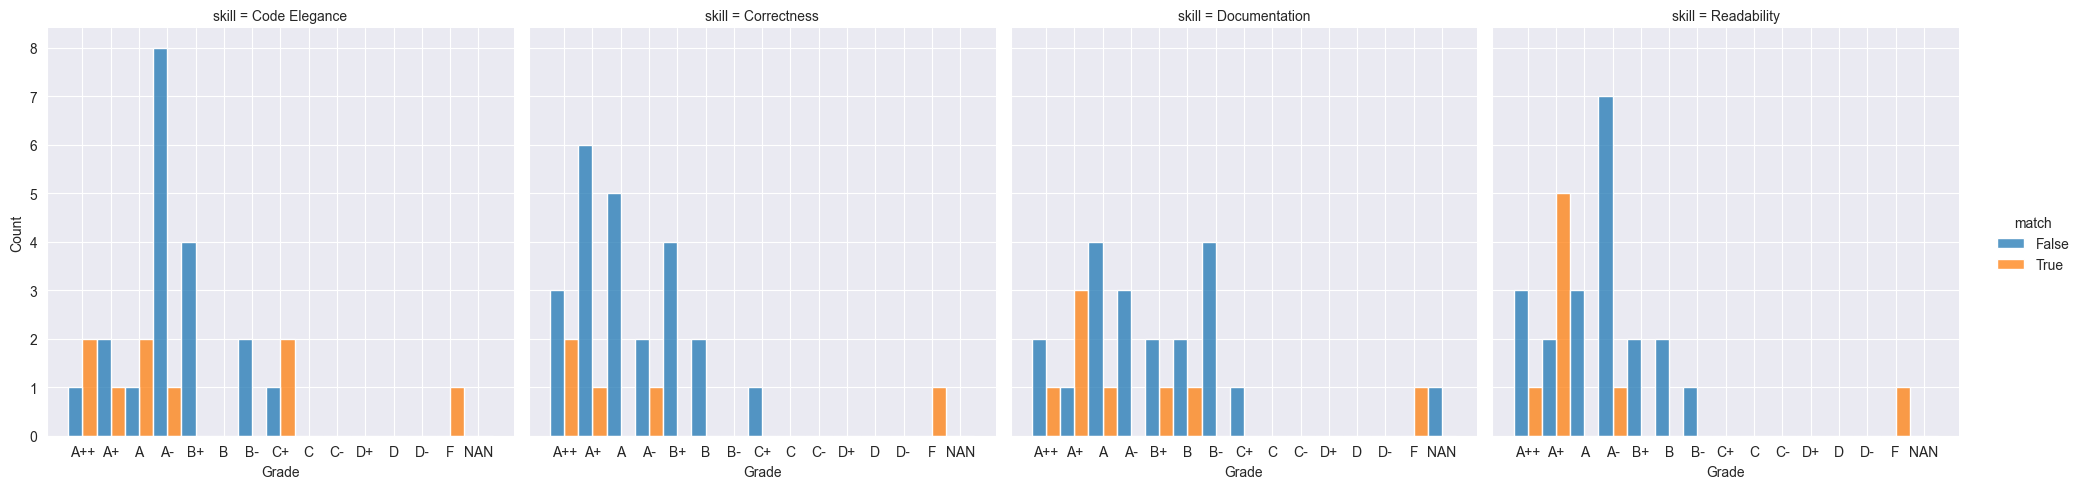

In [46]:
facet_plt = sns.displot(match_df, x='grade_1', col='skill', hue='match', multiple='dodge')
facet_plt.set(xlabel='Grade', ylabel='Count')

# Summary of Grades per skill

In [48]:
grade_count_df = grade_df[['skill', 'grade', 'assignment_number']].groupby(['skill', 'grade']).count().reset_index().rename(columns={'assignment_number': 'count'})
grade_count_df

/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_46899/1988006025.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grade_count_df = grade_df[['skill', 'grade', 'assignment_number']].groupby(['skill', 'grade']).count().reset_index().rename(columns={'assignment_number': 'count'})


,skill,grade,count
0,Code Elegance,A++,148
1,Code Elegance,A+,199
2,Code Elegance,A,191
3,Code Elegance,A-,132
4,Code Elegance,B+,117
5,Code Elegance,B,128
6,Code Elegance,B-,73
7,Code Elegance,C+,53
8,Code Elegance,C,22
9,Code Elegance,C-,13


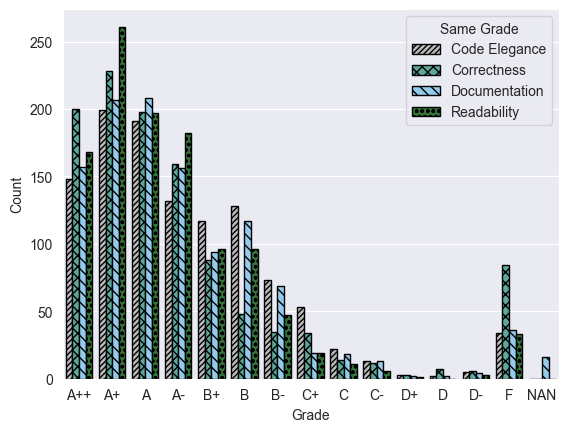

In [52]:
grade_plt = sns.barplot(x='grade', y='count', data=grade_count_df, hue='skill')

hatches = ['//', 'x', '\\', 'o']
colors = [grey, teal, blue, darkgreen]
styles = zip(hatches, colors)


for style, these_bars in zip(styles, grade_plt.containers):
    for this_bar in these_bars:
        this_bar.set_hatch(3 * style[0])
        this_bar.set_facecolor(style[1])
        this_bar.set_edgecolor('black')

grade_plt.set(xlabel='Grade', ylabel='Count')
handles = grade_plt.get_legend_handles_labels()[0]

for i in range(len(handles)):
    handles[i].set_facecolor(colors[i])
    handles[i].set_hatch(3 * hatches[i])
    handles[i].set_edgecolor('black')


grade_plt.legend(title='Same Grade')
grade_plt.get_figure().savefig('plots/grade_count.pdf', bbox_inches='tight')

In [67]:
lower_b = grade_count_df[~grade_count_df['grade'].isin(['A++', 'A+', 'A', 'A-', 'B+', 'B', 'B-'])]['count'].sum()

(lower_b / grade_count_df['count'].sum()) * 100

10.616897630755476

# Feedback Analysis

In [76]:
feedback_df = grade_df[['participant_id', 'assignment_number', 'skill', 'comments']]
feedback_df

,participant_id,assignment_number,skill,comments
0,15,18.0,Readability,The code use meaningful identifier names and a...
1,15,620.0,Readability,Code is well organized into logical classes an...
2,15,466.0,Readability,"The code is well-organized, consistently inden..."
3,15,591.0,Readability,The code is well organized and readable. Inden...
4,15,587.0,Readability,The code is well organized and readable. Inden...
...,...,...,...,...
15,14,58.0,Documentation,NaN
16,14,353.0,Documentation,NaN
17,14,422.0,Documentation,NaN
18,14,480.0,Documentation,NaN


### Count of submissions with no feedback

In [77]:
count_df = feedback_df.groupby('skill').count().reset_index()
count_df['missing'] = count_df['assignment_number'] - count_df['comments']
count_df

,skill,participant_id,assignment_number,comments,missing
0,Code Elegance,1120,1120,677,443
1,Correctness,1116,1116,714,402
2,Documentation,1118,1118,710,408
3,Readability,1120,1120,631,489


<Axes: xlabel='skill', ylabel='missing'>

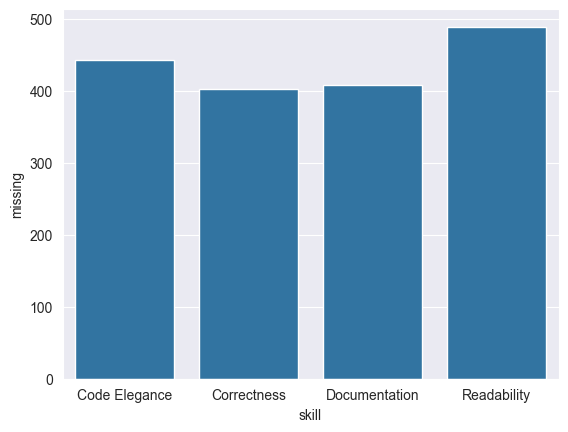

In [78]:
# Maybe add a plot of count of missing at each grade?
sns.barplot(count_df, x='skill', y='missing')

### All unique feedback

In [79]:
unique_feedback_df = feedback_df[['skill', 'comments']]
unique_feedback_df['comments'] = unique_feedback_df['comments'].str.lower()
unique_feedback_df = unique_feedback_df.groupby('skill').value_counts().reset_index()
unique_feedback_df.to_csv('data/unique_feedback.csv', index=False)
unique_feedback_df

/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_45988/389625499.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_feedback_df['comments'] = unique_feedback_df['comments'].str.lower()


,skill,comments,count
0,Code Elegance,"effective use of object-oriented principles, e...",38
1,Code Elegance,"methods are reusable and readable, but some co...",13
2,Code Elegance,the design could have been better.,13
3,Code Elegance,"it is good, though there are little problems h...",11
4,Code Elegance,solid implementation of both core and challeng...,11
...,...,...,...
1844,Readability,"very well written, code is simple and well mai...",1
1845,Readability,well structure and easy to read,1
1846,Readability,"well structured, code is easy to read",1
1847,Readability,with clear variable names and straightforward ...,1
